<a href="https://colab.research.google.com/github/abrhamadam/Computer-vision-and-image-proccessing/blob/main/YOLONAS_kitti_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install super-gradients

# !pip install imutils

# 🪡 Fine-tuning YOLONAS on custom dataset

## 🏋🏽 The trainer

The first thing you need to define in SuperGradients is the Trainer.

The trainer is in charge of training, evaluation, saving checkpoints, etc. If you're interested in seeing the source code for the trainer, you can do so [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/sg_trainer/sg_trainer.py).

### ✌🏼 There's two important arguments to the trainer:

1) `ckpt_root_dir` - this is the directory where results from all your experiments will be saved

2)`experiment_name` - all checkpoints, logs, and tensorboards will be saved in a directory with the name you specify here.


In [ ]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

ModuleNotFoundError: No module named 'super_gradients'

# 💾 Datasets and DataLoaders

SuperGradients is fully compatible with PyTorch Datasets and Dataloaders, so you can use your dataloaders as is.

There are several well-known datasets for object detection, for example:

- COCO
- Pascal
- YOLODarkNet
- YOLOv5

SuperGradients provides ready-to-use dataloaders for these datasets. If you're interested in learning more about working with `COCOFormatDetectionDataset` and the more general `DetectionDataset` [check out the SuperGradients documentation on this topic](https://docs.deci.ai/super-gradients/docstring/training/datasets/#training.datasets.detection_datasets.coco_detection.COCODetectionDataset)

You can learn more about working with SuperGradients datasets, dataloaders, and configuration files [here.](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Data.md)

SuperGradients supports a number of dataset formats, you can learn more about that [here.](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ObjectDetection.md)



In [ ]:
# importing the required modules, which will help us in creating SuperGradients dataloaders.

from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

# loading dataset parameters into a dictionary
dataset_params = {
    'data_dir':'dataset',
    'train_images_dir':'data_object_image_2/training/image_2',
    'train_labels_dir':'data_object_label_2/labels_in_yolo_format/train_labels',
    'val_images_dir':'data_object_image_2/validation/image_2',
    'val_labels_dir':'data_object_label_2/labels_in_yolo_format/val_labels',
    'classes': ['Car', 'Pedestrian','Van','Cyclist',  'Truck', 'Misc', 'Tram','Person_sitting', 'DontCare']
}

# {"Car": 0, "Pedestrian": 1, "Van": 2, "Cyclist": 3, "Truck": 4, "Misc": 5, "Tram": 6, "Person_sitting": 7, "DontCare": 8}

You pass the values for `dataset_params` into the `dataset_params` argument as shown below.

You can also pass PyTorch DataLoaders arguments when instantiating your dataset. Here you'll set `batch_size=16` and `num_workers=2`.

Repeat this for the validation and testing datasets, note that for training and testing data we use `coco_detection_yolo_format_val` to instantiate the dataloader.

The dataloaders will print warnings when an annotation does not conform to the expected format. This particular dataset has many such annotations, thus the warnings will be muted.

In [ ]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)


clear_output()

Indexing dataset annotations: 100%|████████████████████████████| 480/480 [00:00<00:00, 5485.04it/s]


# 👩🏽‍🦳 Instantiating the model

In [ ]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

# 📊 Define metrics and training parameters

You need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.




### 🪄 SuperGradients offers a number of training tricks:
 You can read details about these training tricks [here](https://heartbeat.comet.ml/a-better-way-to-train-your-neural-networks-813b60a5bd6a).


Note you will have to set number of classes in two places below: `PPYoloELoss` and `DetectionMetrics_050`.


### 🔕 Note: I've enabled `silent_mode` so the notebook doesn't get longer than it already is. You should disable it so you can see what SuperGradients outputs during training.

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 200,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)



D:\yolo_NAS_env\myvenv\lib\site-packages\super_gradients\common\registry\registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
D:\yolo_NAS_env\myvenv\lib\site-packages\psutil\_pswindows.py:280: DeprecationWarning: getargs: The 'u' format is deprecated. Use 'U' instead.
  total, free = cext.disk_usage(path)
Validating epoch 200: 100%|██████████| 30/30 [00:18<00:00,  1.60it/s]


In [ ]:
# check checkpoints folder for trained model.

# 🔮 Predicting with the best model


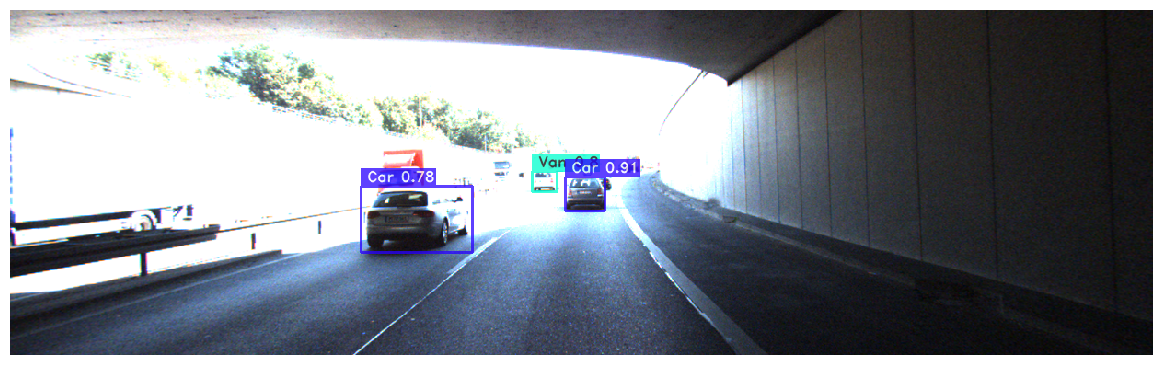

In [ ]:
from super_gradients.training import models

dataset_params = {
    'classes': ['Car', 'Pedestrian','Van','Cyclist',  'Truck', 'Misc', 'Tram','Person_sitting', 'DontCare']
}


best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/my_first_yolonas_run/RUN_20240130_005437_886225/ckpt_best.pth")


test_image = 'test_images/000003.png'
best_model.predict(test_image).show()

Predicting Images:   0%|                                                     | 0/5 [00:00<?, ?it/s]

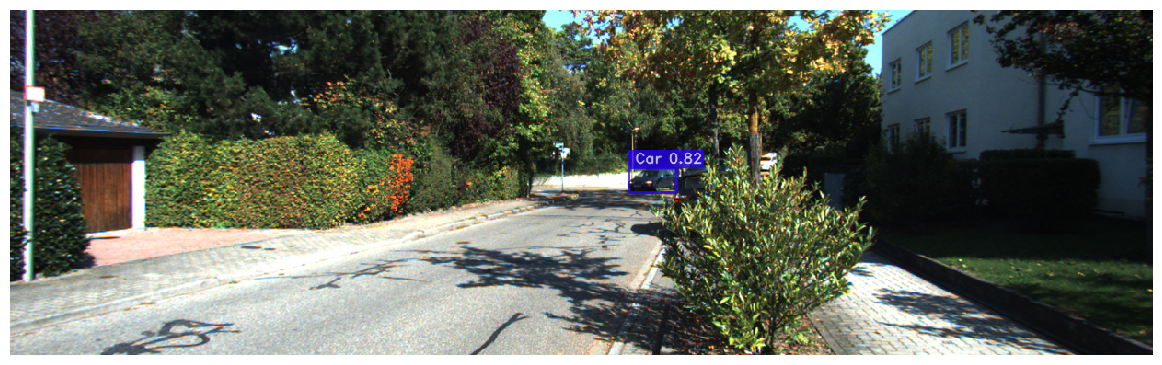

Predicting Images: 100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


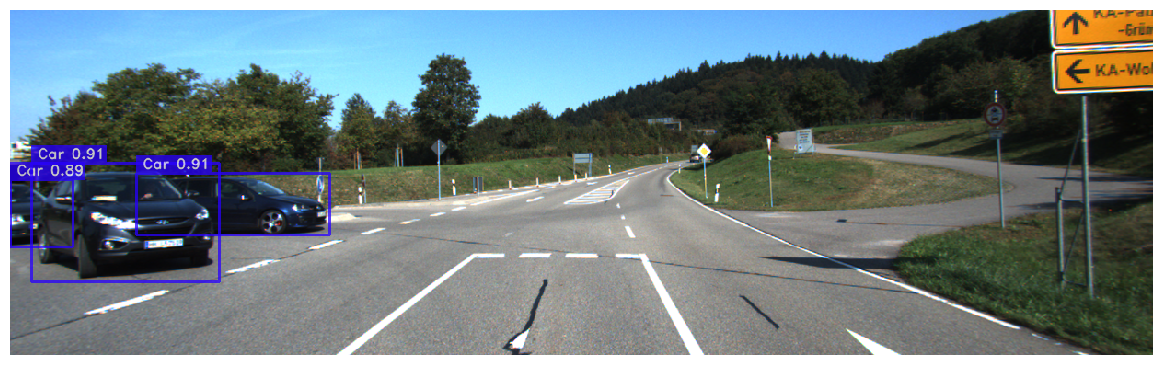

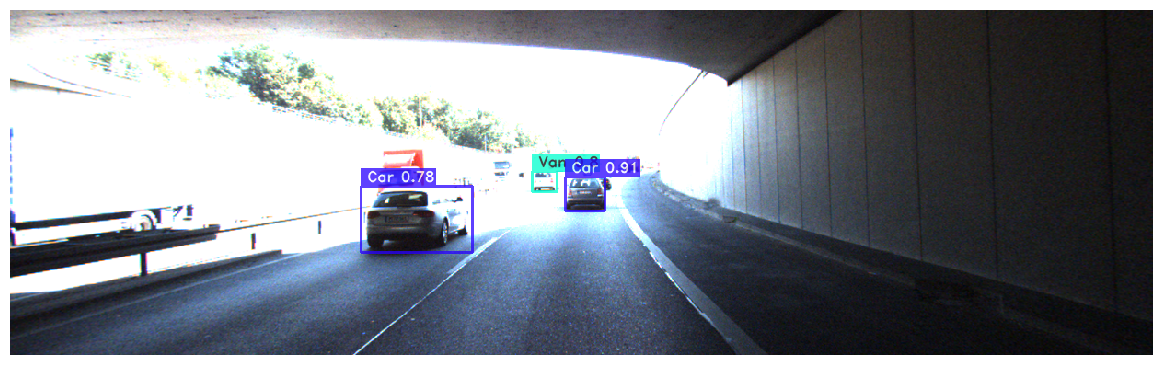

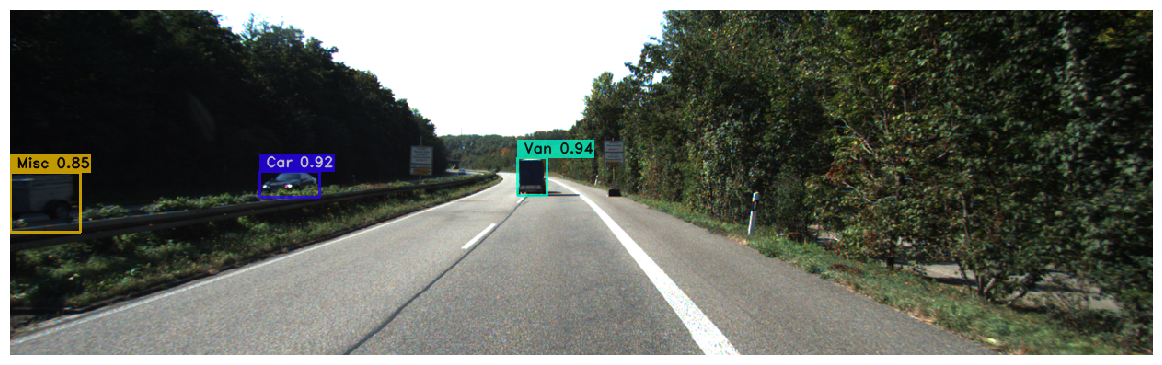

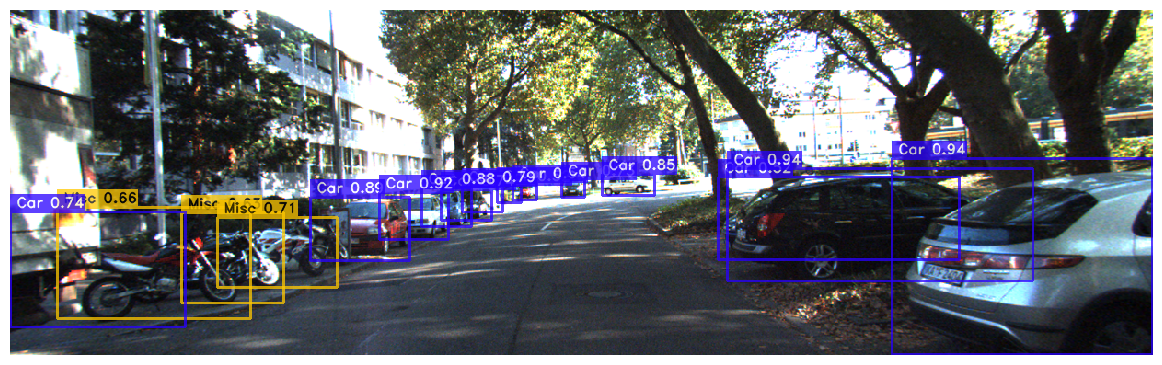

In [ ]:
test_image = 'test_images'
best_model.predict(test_image).show()

# 🎥 Inference on video

In [ ]:
import torch
device = 0 if torch.cuda.is_available() else "cpu"

#input_video_path = "Trim.mp4"
input_video_path = "test_videos/3_in.mp4"
output_video_path = "output_videos/3_out.mp4"
#device=0

best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████████████████████████████████████| 337/337 [00:05<00:00, 66.31it/s]
